In [132]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold 
from sklearn.preprocessing import binarize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score
import instructions
import handling_outliers as ho

In [94]:
path = os.path.split(os.getcwd())
data_directory = os.path.join(path[0], 'data\\raw')
#data_directory = os.path.join(os.getcwd(), 'data\\raw')


X = instructions.load_csv(data_directory, 'train_data')
y = instructions.load_csv(data_directory, 'train_labels')

In [159]:
kpca = KernelPCA(n_components=2, kernel="rbf")

X_kpca = kpca.fit_transform(X)

X_kpca.shape

(3750, 2)

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

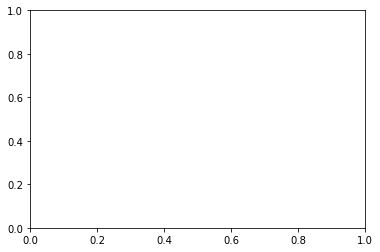

In [166]:
plt.scatter(X_kpca[:,0], X_kpca[:,1])

In [154]:
# normal distribution test

from scipy.stats import normaltest

stat, p = normaltest(X)
stat, p

normal = 0
not_normal = 0

# hipothesis : x comes from a normal distribution

for i in p:
    if i < 0.05:
        not_normal += 1 # hypothesis can be rejected
    else:
        normal += 1 # hypothesis can not be rejected

normal, not_normal

(9490, 510)

In [145]:
p

array([0.82425654, 0.65432097, 0.98708188, ..., 0.08635164, 0.4635971 ,
       0.80054311])

In [19]:
#standarization

scaler = RobustScaler()
X_scal = scaler.fit_transform(pd.DataFrame(X))

In [96]:
X_copy = X.copy()

In [62]:
X_rem = ho.removing_iqr(pd.DataFrame(X_copy))

In [124]:
contamination = X_rem.sum().sum() / (X_rem.shape[0] * X_rem.shape[1])

In [125]:
contamination

0.007063386666666667

In [104]:
masked = ho.mask_outliers(X_copy, X_rem)

In [106]:
replaced = ho.replace_missing_values(masked, 5)

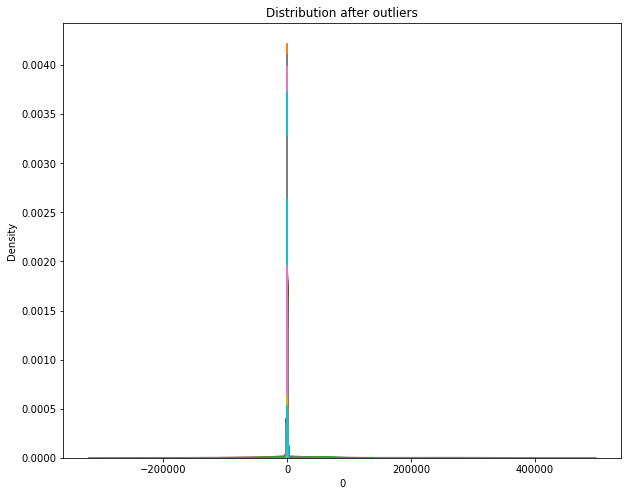

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Distribution after outliers')

for i in replaced:
    sns.kdeplot(replaced[i], ax=ax1)

In [108]:
y_binar = binarize(y)
y = pd.DataFrame(np.ravel(y_binar))

In [109]:
# Create a PCA that will retain 95% of the variance
pca = PCA(n_components=0.95, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(replaced)
X_pca = pd.DataFrame(X_pca)

In [141]:
replaced

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,304.3610,-436.590,-33854.769,-96571.569,-15086.947,-794.409,-442.859,304.248,-202.411,-506.852,...,95.294,-3.936,-251.812,256.429,-473.661,-1398.604,42.638,771.185,-191.123,1356.137
1,54.0470,90.087,-154.747,-4116.486,38365.133,-589.309,1115.367,274.199,814.953,167.272,...,-176.341,-426.238,-542.428,99.147,-102.309,-277.948,-98.859,-1163.779,265.231,-992.056
2,272.1680,-201.736,4212.592,-9123.655,-35422.458,-1029.249,-506.290,-476.856,-570.731,-161.288,...,321.426,-376.033,142.834,920.958,-122.525,-174.304,-137.612,-1571.473,678.323,1020.263
3,170.0070,68.736,48662.079,29735.235,-13903.955,895.081,-257.748,-811.058,-691.561,-31.439,...,-409.919,400.946,313.270,123.172,1786.962,147.637,31.433,-784.719,573.433,1454.415
4,86.7970,180.052,-49643.545,2515.406,26206.315,-407.453,-189.416,-53.664,-159.507,-42.291,...,-101.761,-424.898,37.254,-337.431,423.691,14.240,267.352,-234.560,-213.804,873.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,338.5390,-98.216,-37488.883,-2346.403,-291.325,553.155,1041.511,391.664,1016.730,49.772,...,350.501,-607.873,430.407,-469.737,68.670,328.636,105.448,-368.834,378.017,-253.044
3746,105.5110,-167.468,54447.468,-38055.924,-12394.035,711.218,100.459,-1377.005,-171.175,-325.444,...,4.759,-9.079,104.333,4.676,-1069.879,-92.252,86.110,-4.935,433.674,-355.118
3747,93.1860,-155.288,-16555.534,-10605.421,-3027.792,-80.498,-2201.598,-49.392,-848.946,-252.714,...,-342.855,-151.956,7.386,564.910,613.541,-570.735,-5.810,797.659,-289.170,-91.306
3748,103.6948,98.182,-39429.721,26215.357,-1465.352,-340.496,-992.109,990.646,140.943,-281.100,...,200.827,-1445.572,-39.879,421.075,-191.389,-538.616,141.365,552.974,310.130,207.084


In [158]:
from scipy.stats import normaltest

stat, p = normaltest(replaced)
stat, p

normal = 0
not_normal = 0

# hypothesis : x comes from a normal distribution

for i in p:
    if i < 0.05:
        not_normal += 1 # hypothesis can be rejected
    else:
        normal += 1 # hypothesis can not be rejected

normal, not_normal

(26, 9974)

In [23]:
pipe = Pipeline(steps=[("classifier", LogisticRegression())])

In [32]:
model_params = {
    'svm' : {
        'model' : SVC(kernel='linear'),
        'params' : {
            'C' : [1, 10, 20],
            'gamma' : ['scale', 'auto'],
            'class_weight' : ['balanced']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : [10, 100, 1000],
            'max_features' : ['auto', 'sqrt', 'log2', 'none'],
            'class_weight' : ['balanced']
        }
    },
    'logistic_regression' : {
        'model' : LogisticRegression(solver = 'liblinear', multi_class='auto'),
        'params' : {
            'C' : np.linspace(1, 5, 10),
            'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
            'class_weight' : ['balanced']
        }
    },
    'bernoulliNB' : {
        'model' : BernoulliNB(),
        'params' : {
            'alpha' : np.linspace(1, 10, 100)
        }
    },
    'KN_neighbors' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'weights' : ['uniform', 'distance'],
            'algorithm' : ['auto', 'kd-tree', 'brute'],
            'n_neighbors' : [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
        }
    },
    'MLP' : {
        'model' : MLPClassifier(),
        'params' : {}
    },
    'Decision_tree' : {
        'model' : DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'splitter' : ['best', 'random'],
            'max_features' : ['auto', 'sqrt', 'log2', 'none'],
            'class_weight' : ['balanced']
        }
    },
    'extra_tree' : {
        'model' : ExtraTreesClassifier(),
        'params' : {
            'n_estimators' : [10, 100, 1000],
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'max_features' : ['sqrt', 'log2', 'none'],
            'class_weight' : ['balanced']
        }
    }
}

In [8]:
search_space = [{"classifier" : [LogisticRegression()],
                 "classifier__solver" : ['sag', 'saga', 'liblinear'],
                "classifier__penalty" : ['l1', 'l2', 'elasticnet', 'none'],
                "classifier__C" : [np.logspace(1, 4, 10)],
                "classifier__class_weight" : ['balanced', {"0" : 0.1, "1" : 0.9}]},
                {"classifier" : [BernoulliNB()],
                "classifier__alpha" : [np.linspace(1, 10, 100)]},
                {"classifier" : [RandomForestClassifier()],
                "classifier__n_estimators" : [10, 100, 1000],
                "classifier__criterion" : ['gini', 'entropy', 'log_loss'],
                "classifier__max_features" : ['auto', 'sqrt', 'log2', 'none'],
                "classifier__class_weight" : ['balanced', [{0 : 1}, {1 : 9}]]},
                {"classifier" : [KNeighborsClassifier()],
                "classifier__weights" : ['uniform', 'distance'],
                "classifier__algorithm" : ['auto', 'ball-tree', 'kd-tree', 'brute'],
                "classifier__n_neighbors" : [np.linspace(1, 11, 6)]},
                {"classifier" : [SVC()],
                "classifier__C" : [np.logspace(1, 10000, 1000)],
                "classifier__class_weight" : ['balanced', [{0 : 1}, {1 : 9}]]},
                {"classifier" : [MLPClassifier()]},
                {"classifier" : [DecisionTreeClassifier()],
                "classifier__criterion" : ['gini', 'entropy', 'log_loss'],
                "classifier__splitter" : ['best', 'random'],
                "classifier__max_features" : ['auto', 'sqrt', 'log2', 'none'],
                "classifier__class_weight" : ['balanced', [{0 : 1}, {1 : 9}]]},
                {"classifier" : [ExtraTreesClassifier()],
                "classifier__n_estimators" : [10, 100, 1000],
                "classifier__criterion" : ['gini', 'entropy', 'log_loss'],
                "classifier__max_features" : ['sqrt', 'log2', 'none'],
                "classifier__class_weight" : ['balanced', [{0 : 1}, {1 : 9}]]}]

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\numpy\core\function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


In [9]:


splits = 3
n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=n_repeats)

In [33]:
scores = []

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'], mp['params'], scoring = 'balanced_accuracy', cv = cv)
  clf.fit(X_pca, y.values.flatten())
  scores.append({
      'model': model_name,
      'best_score': clf.best_score_,
      'best_params': clf.best_params_
  })

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\neighbors\_base.py", line 437, in _fit
  

In [34]:
scores

[{'model': 'KN_neighbors',
  'best_score': 0.504352186550435,
  'best_params': {'algorithm': 'auto',
   'n_neighbors': 3,
   'weights': 'uniform'}},
 {'model': 'MLP', 'best_score': 0.4988623231685379, 'best_params': {}},
 {'model': 'Decision_tree',
  'best_score': 0.5102591770058341,
  'best_params': {'class_weight': {0: 1, 1: 9},
   'criterion': 'gini',
   'max_features': 'auto',
   'splitter': 'random'}},
 {'model': 'extra_tree',
  'best_score': 0.5019649613424767,
  'best_params': {'class_weight': {0: 1, 1: 9},
   'criterion': 'gini',
   'max_features': 'sqrt',
   'n_estimators': 10}}]

In [10]:


scoring = ["balanced_accuracy", "f1_weighted"]

search = GridSearchCV(pipe, search_space, cv=rskf, scoring="balanced_accuracy", refit=True, verbose=3)

In [11]:
result = search.fit(X_pca, y)

Fitting 30 folds for each of 210 candidates, totalling 6300 fits
[CV 1/30] END classifier=LogisticRegression(), classifier__C=[   10.            21.5443469     46.41588834   100.
   215.443469     464.15888336  1000.          2154.43469003
  4641.58883361 10000.        ], classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   0.0s
[CV 2/30] END classifier=LogisticRegression(), classifier__C=[   10.            21.5443469     46.41588834   100.
   215.443469     464.15888336  1000.          2154.43469003
  4641.58883361 10000.        ], classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=sag;, score=nan total time=   0.0s
[CV 3/30] END classifier=LogisticRegression(), classifier__C=[   10.            21.5443469     46.41588834   100.
   215.443469     464.15888336  1000.          2154.43469003
  4641.58883361 10000.        ], classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=sag;, s

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 11/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 12/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 13/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 14/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 15/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 16/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 17/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 18/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 19/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 20/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 21/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 22/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 23/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 24/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 25/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 26/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 28/30] END classifier=BernoulliNB(), classifier__alpha=[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.0909

c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 6/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 7/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 8/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 9/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 10/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 11/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 12/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 13/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.8s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 14/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.8s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 15/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 16/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.498 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 17/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.8s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 18/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 19/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 20/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 21/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 22/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 23/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.503 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 24/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 25/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 26/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.499 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 27/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.504 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 28/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 29/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.500 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 30/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=10;, score=0.503 total time=   0.6s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.3s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.1s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.4s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.3s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.1s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 6/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.4s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 7/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   7.2s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 8/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.3s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 9/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.4s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 10/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.1s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 11/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.2s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 12/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.1s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 13/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.3s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 14/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.0s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 15/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.2s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 16/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.0s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 17/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.4s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 18/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.2s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 19/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.3s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 20/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.2s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 21/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.2s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 22/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.4s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 23/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.0s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 24/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.0s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 25/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.3s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 26/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.1s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 27/30] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_features=auto, classifier__n_estimators=100;, score=0.500 total time=   6.7s


c:\Users\Marta\anaconda3\envs\python_in_ml\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


KeyboardInterrupt: 